***Convolutional Neural Network (CNN)***
- Parameter:
    - Layers:
        - rescaling_1 (Rescaling), size = (None, 128, 128, 3)
        - conv2d_2 (Conv2D), size = (None, 128, 128, 32)
        - max_pooling2d_2 (MaxPooling 2D), size = (None, 64, 64, 32)
        - conv2d_3 (Conv2D), size = (None, 64, 64, 64)
        - max_pooling2d_3 (MaxPooling 2D), size = (None, 32, 32, 64)
        - flatten_1 (Flatten), size = (None, 65536)
        - dense_2 (Dense), size = (None, 128) 
        - dropout_1 (Dropout), size = (None, 128)
        - dense_3 (Dense), size = (None, 6)
    - activation function: ReLu
    - output: softmax
    - optimizer = adam

- Evaluierung:
    - Accuracy Gesamt = 74.0 % auf die Testdaten

- Trainingsdatensatz:
    - Features = 128 x 128 (image size)
    - Anzahl Datenpunkte = 12930

- Testdatensatz
    - Features = 128 x 128 (image size)
    - Anzahl Datenpunkte = 339


In [1]:
import os
import tensorflow as tf 
from tensorflow import keras 
from keras.regularizers import L2
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_evaluation_metrices(confusion_matrix, vegi):
    cls = {'Karotte':0, 'Karotte_Trieb':1, 'Kartoffel':2, 'Kartoffel_Trieb':3, 'Zwiebel':4, 'Zwiebel_Trieb':5}[vegi]
    #print(cls)

    tp = confusion_matrix[cls][cls]
    fn = np.sum(confusion_matrix, axis=0)[cls] - tp
    fp = np.sum(confusion_matrix, axis=1)[cls] - tp
    tn = np.sum(confusion_matrix) - (tp + fn + fp)
    print(f"Classifications for {vegi}: tp= {tp} | fn= {fn} | fp= {fp} | tn= {tn}\n")

    acc = round((tp + tn)/ (tp + fn + fp + tn), 2)
    prec = round(tp / (tp + fp), 2)
    rec = round(tp / (tp + fn), 2)
    f1 = round(2 * ((prec * rec) / (prec + rec)), 2)

    return acc, prec, rec, f1

def pretty_print_evaluations(acc, prec, rec, f1, setname, vegi):
    print(f"{vegi.upper()}\nEvaluation scores for {setname}\nAccuracy= {acc} %\nPrecission= {prec} %\nRecall= {rec} %\nF1-Score= {f1} %\n\n{len(vegi)*'-'}")


def evaluate_model(clf, y_label, pred_val, X, type_dataset, kind_confusion_matrix):
    if kind_confusion_matrix == "sklearn":
        disp = ConfusionMatrixDisplay.from_estimator(
            clf,
            X,
            y_label,
            display_labels=['Karotte', 'Kartoffel', 'Zwiebel', 'Karotte_Trieb', 'Kartoffel_Trieb', 'Zwiebel_Trieb'],
            cmap='viridis',
            normalize=None,
        )
        disp.ax_.set_title(f"Confusion Matrix {type_dataset}")
        print(disp.confusion_matrix)
        print("\n\n")

    elif kind_confusion_matrix == "own":
        cm = ConfusionMatrixDisplay.from_predictions(
            y_label,
            pred_val,
            xticks_rotation="vertical",
            display_labels=['Karotte', 'Karotte_Trieb', 'Kartoffel', 'Kartoffel_Trieb', 'Zwiebel', 'Zwiebel_Trieb']
        )
        cm.ax_.set_title(f"Confusion Matrix {type_dataset}")
       

    vegis_list = ['Karotte', 'Karotte_Trieb', 'Kartoffel', 'Kartoffel_Trieb', 'Zwiebel', 'Zwiebel_Trieb']
    conf_matrix = confusion_matrix(y_label, pred_val)
    print("\n\n")
    prec = []
    rec = []
    f1 = []
    for vegi in vegis_list:    
        acc_val, prec_val, rec_val, f1_val = get_evaluation_metrices(conf_matrix, vegi)
        prec.append(prec_val)
        rec.append(rec_val)
        f1.append(f1_val)
        pretty_print_evaluations(acc_val, prec_val, rec_val, f1_val, type_dataset, vegi)
    print(f"***** Means: Precission = {sum(prec)/len(prec)}\n || Recall = {sum(rec)/len(rec)}\n || f1 = {sum(f1)/len(f1)}\n")

In [3]:
img_height = 128
img_width =128
batch_size=32

model = tf.keras.models.load_model("D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/model_final.keras")
model.summary()
class_names = ['Karotte', 'Karotte_Trieb', 'Kartoffel', 'Kartoffel_Trieb', 'Zwiebel', 'Zwiebel_Trieb']

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)            

In [4]:
folders = ['Karotte', 'Karotte_Trieb', 'Kartoffel', 'Kartoffel_Trieb', 'Zwiebel', 'Zwiebel_Trieb']
paths = []
for fold in folders:
    for fname in os.listdir(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/Test_set/{fold}"):
        paths.append(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/Test_set/{fold}/{fname}")
paths[:3]   

['D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/Test_set/Karotte/karotte_1.jpg',
 'D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/Test_set/Karotte/karotte_10.jpg',
 'D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN/Test_set/Karotte/karotte_11.jpg']

In [21]:
paths_train = []
for fold in folders:
    for fname in os.listdir(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN_Data_augumentation/{fold}"):
        paths_train.append(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN_Data_augumentation/{fold}/{fname}")
paths_train[:3] 

['D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN_Data_augumentation/Karotte/karotte_0.jpg',
 'D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN_Data_augumentation/Karotte/karotte_1.jpg',
 'D:/Dokumente/Master-Studium/Semester3/KI_Projekt/CNN_Data_augumentation/Karotte/karotte_10.jpg']

In [6]:

classes = {'Karotte':0, 'Karotte_Trieb':1, 'Kartoffel':2, 'Kartoffel_Trieb':3, 'Zwiebel':4, 'Zwiebel_Trieb':5}


In [7]:
i = 0
y_label = []
pred_y = []

for path in paths:
    if "desktop.ini" in path:
        continue
    #vegi_BGR = cv2.imread(path)
    #plt.imshow(vegi_BGR)
    #plt.show()
    y_label.append(classes[path.split("/")[7]])

    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    test_array = tf.keras.utils.img_to_array(img)
    test_array = tf.expand_dims(test_array, 0)

    predictions = model.predict(test_array)
    score = tf.nn.softmax(predictions[0])
    #print(predictions)
    
    #print(
    #    "This image most likely belongs to {} "
    #    .format(class_names[np.argmax(score)])
    #)
    pred_vegi = class_names[np.argmax(score)]
    #print("#### pred_vegi", pred_vegi)
    pred_y.append(classes[class_names[np.argmax(score)]])


1/1 [==============================] - 0s 31ms/step


In [8]:
i = 0
y_label_train = []
pred_y_train = []

for path in paths_train:
    if "desktop.ini" in path:
        continue
    #vegi_BGR = cv2.imread(path)
    #plt.imshow(vegi_BGR)
    #plt.show()
    y_label_train.append(classes[path.split("/")[6]])

    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    test_array = tf.keras.utils.img_to_array(img)
    test_array = tf.expand_dims(test_array, 0)

    predictions = model.predict(test_array)
    score = tf.nn.softmax(predictions[0])
    #print(predictions)
    
    #print(
    #    "This image most likely belongs to {} "
    #    .format(class_names[np.argmax(score)])
    #)
    pred_vegi = class_names[np.argmax(score)]
    #print("#### pred_vegi", pred_vegi)
    pred_y_train.append(classes[class_names[np.argmax(score)]])

1/1 [==============================] - 0s 50ms/step


Model Accuracy Train-&valset: 0.9846944236326661 %
Model Accuracy Testset: 0.8171091445427728 %




Classifications for Karotte: tp= 1764 | fn= 17 | fp= 9 | tn= 7553

KAROTTE
Evaluation scores for Train-&valset
Accuracy= 1.0 %
Precission= 0.99 %
Recall= 0.99 %
F1-Score= 0.99 %

-------
Classifications for Karotte_Trieb: tp= 1547 | fn= 22 | fp= 8 | tn= 7766

KAROTTE_TRIEB
Evaluation scores for Train-&valset
Accuracy= 1.0 %
Precission= 0.99 %
Recall= 0.99 %
F1-Score= 0.99 %

-------------
Classifications for Kartoffel: tp= 2127 | fn= 24 | fp= 57 | tn= 7135

KARTOFFEL
Evaluation scores for Train-&valset
Accuracy= 0.99 %
Precission= 0.97 %
Recall= 0.99 %
F1-Score= 0.98 %

---------
Classifications for Kartoffel_Trieb: tp= 1035 | fn= 48 | fp= 26 | tn= 8234

KARTOFFEL_TRIEB
Evaluation scores for Train-&valset
Accuracy= 0.99 %
Precission= 0.98 %
Recall= 0.96 %
F1-Score= 0.97 %

---------------
Classifications for Zwiebel: tp= 1929 | fn= 26 | fp= 4 | tn= 7384

ZWIEBEL
Evaluation scores for Tra

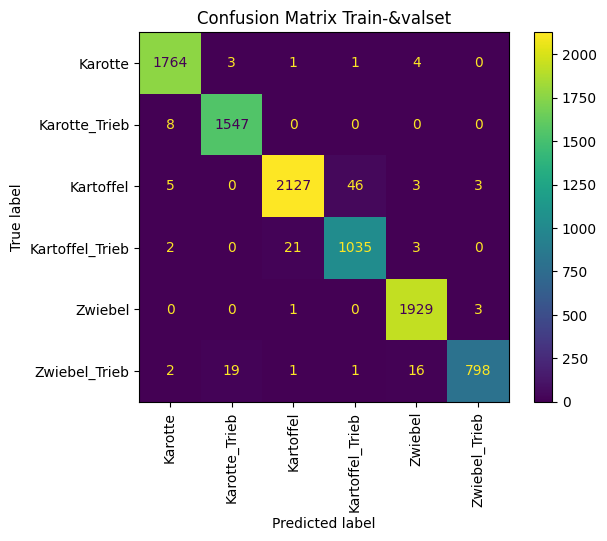

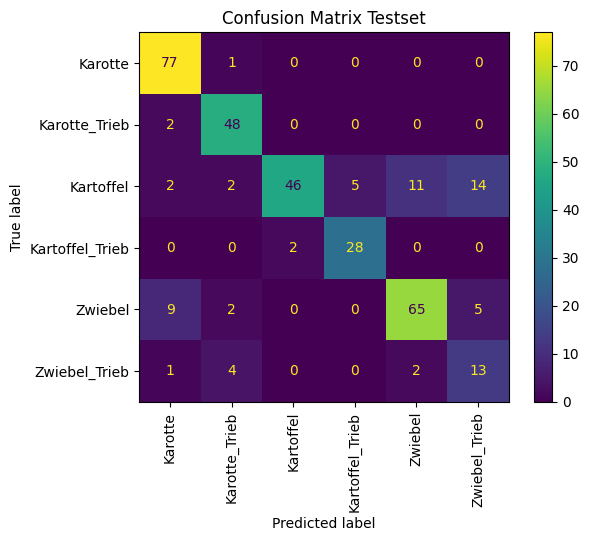

In [9]:
accuracy_train = accuracy_score(y_label_train,pred_y_train)
accuracy_test = accuracy_score(y_label,pred_y)
print(f"Model Accuracy Train-&valset: {accuracy_train} %\nModel Accuracy Testset: {accuracy_test} %\n")

evaluate_model(model,y_label_train,pred_y_train,test_array,"Train-&valset","own")
evaluate_model(model,y_label,pred_y,test_array,"Testset","own")

Vorhersagen auf die Prüfungs-Testdaten mit dem Modell CNN (sklearn)

In [20]:
paths_test = []
for fold in folders:
    for fname in os.listdir(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/Gemuesebilder_Pruefung/{fold}"):
        paths_test.append(f"D:/Dokumente/Master-Studium/Semester3/KI_Projekt/Gemuesebilder_Pruefung/{fold}/{fname}")
paths_test[1] 

'D:/Dokumente/Master-Studium/Semester3/KI_Projekt/Gemuesebilder_Pruefung/Karotte/karotte_2.JPG'

In [22]:
#TODO Adapt path to testimages
i = 0
y_label_test_e = []
pred_y_test_e = []

for path in paths_test:
    if "desktop.ini" in path:
        continue

    y_label_test_e.append(classes[path.split("/")[6]])

    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    test_array = tf.keras.utils.img_to_array(img)
    test_array = tf.expand_dims(test_array, 0)

    predictions = model.predict(test_array)
    score = tf.nn.softmax(predictions[0])

    pred_vegi = class_names[np.argmax(score)]

    pred_y_test_e.append(classes[class_names[np.argmax(score)]])

1/1 [==============================] - 0s 38ms/step


Model Accuracy Exam Testset: 0.7142857142857143 %



ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (6).

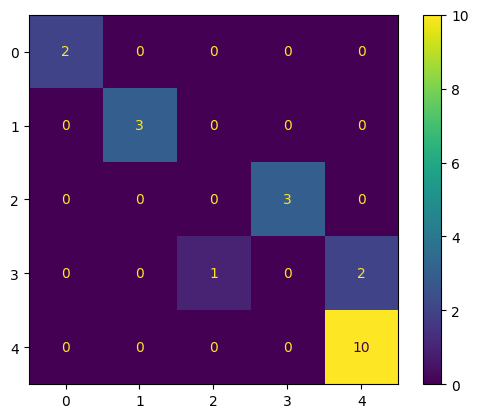

In [38]:
accuracy_test_e = accuracy_score(y_label_test_e, pred_y_test_e)
print(f"Model Accuracy Exam Testset: {accuracy_test_e} %\n")

evaluate_model(model, y_label_test_e, pred_y_test_e, test_array, "Testset Exam", "own")

1/1 [==============================] - 0s 66ms/step
[[3.1794652e-03 5.4289375e-13 2.4980803e-18 5.3794625e-20 9.9682033e-01
  2.0845086e-07]]
This image most likely belongs to Zwiebel with a 35.13 percent confidence.


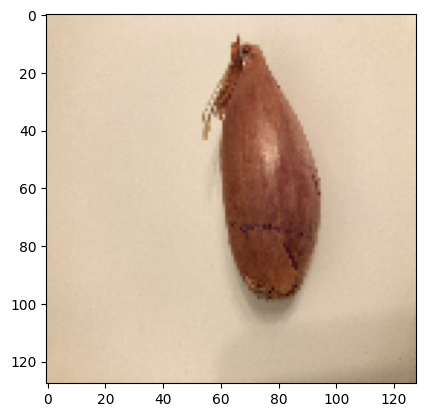

In [41]:
test=tf.keras.utils.load_img('D:/Dokumente/Master-Studium/Semester3/KI_Projekt/Gemuesebilder_Pruefung/Zwiebel/Zwiebel_3.JPG', target_size=(img_height, img_width))
test_array = tf.keras.utils.img_to_array(test)
test_array = tf.expand_dims(test_array, 0)

prediction = model.predict(test_array)
score = tf.nn.softmax(prediction[0])
print(prediction)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
plt.imshow(test)